<a href="https://colab.research.google.com/github/yemanzhongting/MultiCity/blob/main/keras_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English-to-Spanish translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2021/05/26<br>
**Last modified:** 2021/05/26<br>
**Description:** Implementing a sequence-to-sequene Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [233]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [234]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [235]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

In [236]:
text_file

PosixPath('/root/.keras/datasets/spa-eng/spa.txt')

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [237]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [238]:
with open('/content/drive/MyDrive/data/sv-sub.txt') as f:
    lines = f.readlines()
text_pairs = []
for line in lines:
    eng, spa = line.strip().split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [239]:
text_pairs[0]

('Tree Plant House Window Car Land Street Billboard Tire',
 '[start] 物流速递 住宅区 美容美发店 公司 中餐厅 诊所 政府机关 福特特约维修 临街院门 交通地名 [end]')

In [240]:
text_pairs[0]

('Tree Plant House Window Car Land Street Billboard Tire',
 '[start] 物流速递 住宅区 美容美发店 公司 中餐厅 诊所 政府机关 福特特约维修 临街院门 交通地名 [end]')

Here's what our sentence pairs look like:

In [241]:
for _ in range(5):
    print(random.choice(text_pairs))

('Tree Plant Window Car Wheel House Building Skyscraper Street Vehicle', '[start] 中餐厅 大众特约销售 家居建材市场 公交车站 生活服务场所 停车场 临街院门 银行 医药保健销售店 自动提款机 [end]')
('Building Window Plant Car Wheel Skyscraper Tree Street House Land', '[start] 娱乐场所 中餐厅 美容美发店 生活服务场所 临街院门 物流速递 宾馆酒店 公检法机构 餐饮相关场所 汽车养护/装饰 [end]')
('Tree Window Wheel Plant Car Building Land Skyscraper Street Tower', '[start] 临街院门 汽车配件销售 住宅区 中餐厅 政府机关 学校 交通地名 培训机构 科教文化场所 停车场 [end]')
('Tree Building Window Car Wheel Street Land Vehicle Skyscraper Tire', '[start] 停车场 农林牧渔基地 住宅区 自动提款机 学校 宾馆酒店 公司 洗浴推拿场所 临街院门 旅馆招待所 [end]')
('Tree Plant Building House Car Window', '[start] 临街院门 公司 停车场 农林牧渔基地 生活服务场所 宾馆酒店 福特特约维修 产业园区 商务住宅相关 物流速递 [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [242]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

20790 total pairs
20790 training pairs
3118 validation pairs
3118 test pairs


In [243]:
test_pairs[0]

('Tree Window Person Building Car Wheel Bus Land Footwear Truck',
 '[start] 停车场 中餐厅 科教文化场所 生活服务场所 传媒机构 农林牧渔基地 楼宇 临街院门 冷饮店 宾馆酒店 [end]')

## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

##对文本数据进行矢量化

我们将使用 "TextVectorization "层的两个实例来对文本数据进行矢量化。
数据（一个用于英语，一个用于西班牙语）。
也就是说，将原始字符串变成整数序列
其中每个整数代表词汇表中的一个词的索引。

英语层将使用默认的字符串标准化（去除标点符号
和分割方案（在空白处分割），而
而西班牙语层将使用一个自定义的标准化，我们在其中添加字符
`"¿"`到要剥离的标点符号集合中。

注意：在一个生产级的机器翻译模型中，我不建议
剥离两种语言中的标点符号。相反，我建议将
把每个标点符号变成自己的标记。
你可以通过为 "文本矢量化 "层提供一个自定义的 "分割 "函数来实现。

In [244]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 200
sequence_length = 10
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [245]:
train_spa_texts[0]

'[start] 公司 中餐厅 生活服务场所 临街院门 医药保健销售店 学校 政府机关 餐饮相关场所 快餐厅 婴儿服务场所 [end]'

In [246]:
train_eng_texts[0]

'Tree Window House Wheel Car Footwear Land Person Tire Flower'

In [247]:
eng_vectorization.adapt(train_eng_texts)

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [248]:
eng_vectorization("Tree Plant Car Land Street Flower House")

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 2,  8,  5, 10, 11, 17,  7,  0,  0,  0])>

In [249]:
spa_vectorization('[start] 中餐厅 生活服务场所 临街院门 停车场 风景名胜 培训机构 公司 娱乐场所 商务住宅相关 售票处 [end]')

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2,  6,  4,  5,  8, 40, 18, 10, 17, 54, 61])>

In [250]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])

In [251]:
# format_dataset("You don't seem very concerned.", 'No pareces muy preocupado.')

In [252]:
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [253]:
train_ds

<CacheDataset shapes: ({encoder_inputs: (None, 10), decoder_inputs: (None, 10)}, (None, 10)), types: ({encoder_inputs: tf.int64, decoder_inputs: tf.int64}, tf.int64)>

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [254]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 10)
inputs["decoder_inputs"].shape: (64, 10)
targets.shape: (64, 10)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

## 构建模型

我们的序列到序列的转换器由一个 "TransformerEncoder "和一个 "TransformerDecoder "组成。
和一个 "TransformerDecoder "链在一起。为了使模型能够意识到词的顺序。
我们还使用了一个 "位置嵌入 "层。

源序列将被传递给 "转化器编码器"。
它将产生一个新的表示。
然后这个新的表示将被传递给
到 "TransformerDecoder"，连同到目前为止的目标序列（目标字0到N）。
然后`TransformerDecoder'将寻求预测目标序列中的下一个词（N+1及以后）。

使之成为可能的一个关键细节是因果掩码
(见`TransformerDecoder'上的`get_causal_attention_mask()'方法)。
变换器解码器 "一次就能看到整个序列，因此我们必须确保它只使用目标信息。
因此我们必须确保它在预测N+1号标记时只使用目标标记0到N的信息。
(的信息（否则，它可能使用未来的信息，这将导致
否则，它可能会使用未来的信息，这将导致在推理时不能使用的模型）。)

In [255]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )

        # print(attention_output)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output),attention_output


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


Next, we assemble the end-to-end model.

In [256]:
embed_dim = 128#256
latent_dim = 1024#2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

In [257]:
TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

(<KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'transformer_encoder_12')>,
 <KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'transformer_encoder_12')>)

In [258]:
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)[0]
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

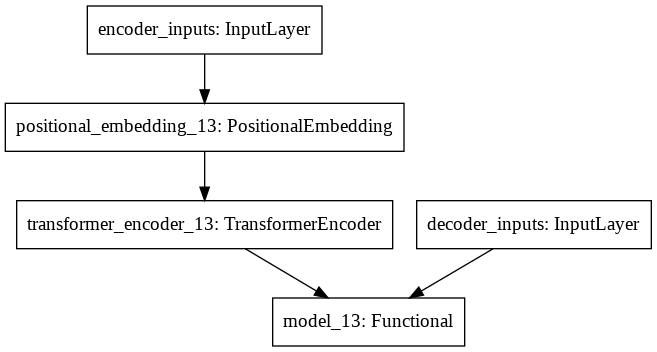

In [259]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
transformer, to_file='model.png'
)
# , show_shapes=False, show_dtype=False,
# show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# plot_model(transformer, to_file='model.png')

In [260]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs)#, validation_data=val_ds

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_13 (Positi (None, None, 128)    26880       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_13 (Transfo ((None, None, 128),  1318656     positional_embedding_13[0][0]    
________________________________________________________________________________________

In [261]:
epochs = 20  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)#

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_13 (Positi (None, None, 128)    26880       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_13 (Transfo ((None, None, 128),  1318656     positional_embedding_13[0][0]    
________________________________________________________________________________________

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [262]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 10

In [263]:
# spa_index_lookup

In [264]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # print(predictions)
        # print(predictions.shape)

        sampled_token_index = np.argmax(predictions[0, i, :])

        # print(sampled_token_index)

        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [265]:
test_pairs[0]

('Tree Window Person Building Car Wheel Bus Land Footwear Truck',
 '[start] 停车场 中餐厅 科教文化场所 生活服务场所 传媒机构 农林牧渔基地 楼宇 临街院门 冷饮店 宾馆酒店 [end]')

In [266]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(1):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(translated)

[start] 中餐厅 生活服务场所 临街院门 住宅区 美容美发店 医药保健销售店 物流速递 洗浴推拿场所 物流速递 餐饮相关场所


In [267]:
!pip install rouge-score
from rouge_score import rouge_scorer
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re

from nltk.stem import porter
import six
from six.moves import map
from six.moves import range
from rouge_score import scoring
# from rouge_score import tokenize


class RougeScorer(scoring.BaseScorer):
  """Calculate rouges scores between two blobs of text.

  Sample usage:
    scorer = RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score('The quick brown fox jumps over the lazy dog',
                          'The quick brown dog jumps on the log.')
  """

  def __init__(self, rouge_types, use_stemmer=False):
    """Initializes a new RougeScorer.

    Valid rouge types that can be computed are:
      rougen (e.g. rouge1, rouge2): n-gram based scoring.
      rougeL: Longest common subsequence based scoring.

    Args:
      rouge_types: A list of rouge types to calculate.
      use_stemmer: Bool indicating whether Porter stemmer should be used to
        strip word suffixes to improve matching.
    Returns:
      A dict mapping rouge types to Score tuples.
    """

    self.rouge_types = rouge_types
    self._stemmer = porter.PorterStemmer() if use_stemmer else None

  def score(self, target, prediction):
    """Calculates rouge scores between the target and prediction.

    Args:
      target: Text containing the target (ground truth) text.
      prediction: Text containing the predicted text.
    Returns:
      A dict mapping each rouge type to a Score object.
    Raises:
      ValueError: If an invalid rouge type is encountered.
    """

    target_tokens = tokenize(target, self._stemmer)
    prediction_tokens = tokenize(prediction, self._stemmer)
    result = {}

    for rouge_type in self.rouge_types:
      if rouge_type == "rougeL":
        # Rouge from longest common subsequences.
        scores = _score_lcs(target_tokens, prediction_tokens)
      elif rouge_type == "rougeLsum":
        # Note: Does not support multi-line text.
        def get_sents(text):
          # Assume sentences are separated by newline.
          sents = six.ensure_str(text).split("\n")
          sents = [x for x in sents if len(x)]
          return sents

        target_tokens_list = [
            tokenize(s, self._stemmer) for s in get_sents(target)]
        prediction_tokens_list = [
            tokenize(s, self._stemmer) for s in get_sents(prediction)]
        scores = _summary_level_lcs(target_tokens_list,
                                    prediction_tokens_list)
      elif re.match(r"rouge[0-9]$", six.ensure_str(rouge_type)):
        # Rouge from n-grams.
        n = int(rouge_type[5:])
        if n <= 0:
          raise ValueError("rougen requires positive n: %s" % rouge_type)
        target_ngrams = _create_ngrams(target_tokens, n)
        prediction_ngrams = _create_ngrams(prediction_tokens, n)
        scores = _score_ngrams(target_ngrams, prediction_ngrams)
      else:
        raise ValueError("Invalid rouge type: %s" % rouge_type)
      result[rouge_type] = scores

    return result


def _create_ngrams(tokens, n):
  """Creates ngrams from the given list of tokens.

  Args:
    tokens: A list of tokens from which ngrams are created.
    n: Number of tokens to use, e.g. 2 for bigrams.
  Returns:
    A dictionary mapping each bigram to the number of occurrences.
  """

  ngrams = collections.Counter()
  for ngram in (tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)):
    ngrams[ngram] += 1
  return ngrams


def _score_lcs(target_tokens, prediction_tokens):
  """Computes LCS (Longest Common Subsequence) rouge scores.

  Args:
    target_tokens: Tokens from the target text.
    prediction_tokens: Tokens from the predicted text.
  Returns:
    A Score object containing computed scores.
  """

  if not target_tokens or not prediction_tokens:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  # Compute length of LCS from the bottom up in a table (DP appproach).
  lcs_table = _lcs_table(target_tokens, prediction_tokens)
  lcs_length = lcs_table[-1][-1]

  precision = lcs_length / len(prediction_tokens)
  recall = lcs_length / len(target_tokens)
  fmeasure = scoring.fmeasure(precision, recall)

  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _lcs_table(ref, can):
  """Create 2-d LCS score table."""
  rows = len(ref)
  cols = len(can)
  lcs_table = [[0] * (cols + 1) for _ in range(rows + 1)]
  for i in range(1, rows + 1):
    for j in range(1, cols + 1):
      if ref[i - 1] == can[j - 1]:
        lcs_table[i][j] = lcs_table[i - 1][j - 1] + 1
      else:
        lcs_table[i][j] = max(lcs_table[i - 1][j], lcs_table[i][j - 1])
  return lcs_table


def _backtrack_norec(t, ref, can):
  """Read out LCS."""
  i = len(ref)
  j = len(can)
  lcs = []
  while i > 0 and j > 0:
    if ref[i - 1] == can[j - 1]:
      lcs.insert(0, i-1)
      i -= 1
      j -= 1
    elif t[i][j - 1] > t[i - 1][j]:
      j -= 1
    else:
      i -= 1
  return lcs


def _summary_level_lcs(ref_sent, can_sent):
  """ROUGE: Summary-level LCS, section 3.2 in ROUGE paper.

  Args:
    ref_sent: list of tokenized reference sentences
    can_sent: list of tokenized candidate sentences

  Returns:
    summary level ROUGE score
  """
  if not ref_sent or not can_sent:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  m = sum(map(len, ref_sent))
  n = sum(map(len, can_sent))
  if not n or not m:
    return scoring.Score(precision=0, recall=0, fmeasure=0)

  # get token counts to prevent double counting
  token_cnts_r = collections.Counter()
  token_cnts_c = collections.Counter()
  for s in ref_sent:
    # s is a list of tokens
    token_cnts_r.update(s)
  for s in can_sent:
    token_cnts_c.update(s)

  hits = 0
  for r in ref_sent:
    lcs = _union_lcs(r, can_sent)
    # Prevent double-counting:
    # The paper describes just computing hits += len(_union_lcs()),
    # but the implementation prevents double counting. We also
    # implement this as in version 1.5.5.
    for t in lcs:
      if token_cnts_c[t] > 0 and token_cnts_r[t] > 0:
        hits += 1
        token_cnts_c[t] -= 1
        token_cnts_r[t] -= 1

  recall = hits / m
  precision = hits / n
  fmeasure = scoring.fmeasure(precision, recall)
  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)


def _union_lcs(ref, c_list):
  """Find union LCS between a ref sentence and list of candidate sentences.

  Args:
    ref: list of tokens
    c_list: list of list of indices for LCS into reference summary

  Returns:
    List of tokens in ref representing union LCS.
  """
  lcs_list = [lcs_ind(ref, c) for c in c_list]
  return [ref[i] for i in _find_union(lcs_list)]


def _find_union(lcs_list):
  """Finds union LCS given a list of LCS."""
  return sorted(list(set().union(*lcs_list)))


def lcs_ind(ref, can):
  """Returns one of the longest lcs."""
  t = _lcs_table(ref, can)
  return _backtrack_norec(t, ref, can)


def _score_ngrams(target_ngrams, prediction_ngrams):
  """Compute n-gram based rouge scores.

  Args:
    target_ngrams: A Counter object mapping each ngram to number of
      occurrences for the target text.
    prediction_ngrams: A Counter object mapping each ngram to number of
      occurrences for the prediction text.
  Returns:
    A Score object containing computed scores.
  """

  intersection_ngrams_count = 0
  for ngram in six.iterkeys(target_ngrams):
    intersection_ngrams_count += min(target_ngrams[ngram],
                                     prediction_ngrams[ngram])
  target_ngrams_count = sum(target_ngrams.values())
  prediction_ngrams_count = sum(prediction_ngrams.values())

  precision = intersection_ngrams_count / max(prediction_ngrams_count, 1)
  recall = intersection_ngrams_count / max(target_ngrams_count, 1)
  fmeasure = scoring.fmeasure(precision, recall)

  return scoring.Score(precision=precision, recall=recall, fmeasure=fmeasure)

## 来进行数据验证

In [268]:
def tokenize(text, stemmer):
  """Tokenize input text into a list of tokens.

  This approach aims to replicate the approach taken by Chin-Yew Lin in
  the original ROUGE implementation.

  Args:
    text: A text blob to tokenize.
    stemmer: An optional stemmer.

  Returns:
    A list of string tokens extracted from input text.
  """

  # Convert everything to lowercase.
  text = text.lower()
  # Replace any non-alpha-numeric characters with spaces.
  # text = re.sub(r"[^a-z0-9]+", " ", six.ensure_str(text))
  # ^ [ / u4E00 - / u9FFF]+$
  tokens = re.split(r"\s+", text)

  # print(tokens)
  # print(1)
  if stemmer:
    # Only stem words more than 3 characters long.
    tokens = [stemmer.stem(x) if len(x) > 3 else x for x in tokens]

  # print(tokens)
  # print(2)
  # print(six.ensure_str(x))
  # One final check to drop any empty or invalid tokens.
  # tokens = [x for x in tokens if re.match(r"^[/u4E00 - /u9FFF]+$", six.ensure_str(x))]
  # tokens = [x for x in tokens if re.match(r"^[a-z0-9]+$", six.ensure_str(x))]
  tokens=[x for x in tokens if six.ensure_str]


  # print(tokens)
  # print(3)
  return tokens

In [269]:
test_eng_texts = [pair[0] for pair in train_pairs]
for _ in range(1):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(translated)

[start] 中餐厅 生活服务场所 临街院门 公司 美容美发店 住宅区 停车场 医药保健销售店 娱乐场所 彩票彩券销售点


In [270]:
# train_

In [271]:
A=[]
B=[]
C=[]
scorer = RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
for seq_index in range(0,300):
  # translated = decode_sequence(train_pairs[seq_index][0])
  scores =  scorer.score(train_pairs[seq_index][1].replace('[start]',"").replace('[end]','').strip(),
  decode_sequence(train_pairs[seq_index][0]).replace('[start]',"").replace('[end]','').strip())
  # print(scores['rouge1'])
  tmp=scores['rouge1']
  A.append(tmp[0])
  B.append(tmp[1])
  C.append(tmp[2])

## 查看数据得分

In [272]:
scores

{'rouge1': Score(precision=0.4, recall=0.4, fmeasure=0.4000000000000001),
 'rougeL': Score(precision=0.3, recall=0.3, fmeasure=0.3)}

In [273]:
decode_sequence(train_pairs[1][0]).replace('[start]',"").strip()

'停车场 临街院门 生活服务场所 住宅区 美容美发店 中餐厅 洗浴推拿场所 医药保健销售店 物流速递 诊所'

In [274]:
import numpy as np
print(np.mean(A))
print(np.mean(B))
print(np.mean(C))

0.495
0.4925555555555556
0.493462962962963


After 30 epochs, we get results such as:

> She handed him the money.
> [start] ella le pasó el dinero [end]

> Tom has never heard Mary sing.
> [start] tom nunca ha oído cantar a mary [end]

> Perhaps she will come tomorrow.
> [start] tal vez ella vendrá mañana [end]

> I love to write.
> [start] me encanta escribir [end]

> His French is improving little by little.
> [start] su francés va a [UNK] sólo un poco [end]

> My hotel told me to call you.
> [start] mi hotel me dijo que te [UNK] [end]